## 函数与层

In [1]:
#参考资料：《深度学习入门：基于python的理论与实现（斋藤康毅）》
#均为一行一个样本

from mnist import load_mnist
import numpy as np
from collections import OrderedDict


def softmax(x):
    if x.ndim == 2: #x维度为2，即x为矩阵时
        x = x.T
        x = x - np.max(x, axis=0)  #不论是axis=0还是axis=1，np.max(x, axis=xx)出来必为一个行向量，所以要转置再转置
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    #若不加上面的if这一段，则很可能会溢出，导致模型表现极差
    x = x - np.max(x) # 溢出对策
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 监督数据是one-hot-vector的情况下，转换为正确解标签的索引
    if t.size == y.size:
        t = t.argmax(axis=1)  #y的一行变成一个数
             
    batch_size = y.shape[0] #0轴维度，即行数
    # print(-np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size)
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size #平均：输出每个样本的交叉熵。y是样本行排的概率阵。

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)  #非正的位置
        out = x.copy()
        out[self.mask] = 0  #非正的元素设为0，其他不变

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 权重和偏置参数的导数
        self.dW = None
        self.db = None

    def forward(self, x):
       
        self.x = x

        out = np.dot(self.x, self.W) + self.b  #因为这里是样本行排的（一行一个样本）

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmax的输出
        self.t = None # 监督数据

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 监督数据是one-hot-vector的情况，t有一个值为1
            dx = (self.y - self.t) / batch_size  #反向时为：y-t
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1  #相当于onehot时的y-t，这个1就是在模拟onehot里面的那个1
            dx = dx / batch_size  #平均
        
        return dx

## 二层网络

0.14741666666666667 0.1473
0.9048 0.9077
0.9246 0.9254
0.93435 0.9333
0.94595 0.943
0.9495166666666667 0.9465
0.9554166666666667 0.9508
0.9599 0.9566
0.963 0.9585
0.9653166666666667 0.9605
0.968 0.9621
0.97045 0.9628
0.9724166666666667 0.9655
0.9743166666666667 0.9668
0.9745833333333334 0.9672
0.9769666666666666 0.9675
0.9788666666666667 0.9682


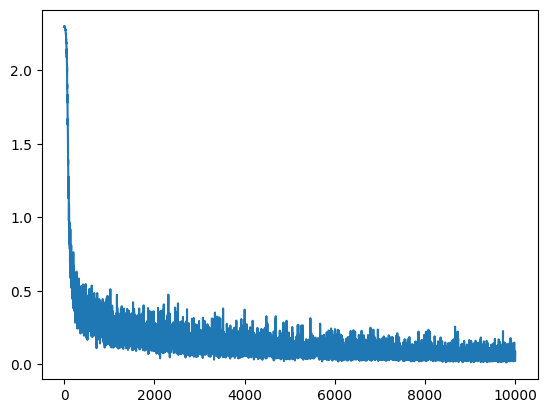

In [10]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 初始化权重：用随机的小值
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()  #有序字典
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():  #类对象组成的列表
            x = layer.forward(x)
        
        return x
        
    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : 
            t = np.argmax(t, axis=1)  #将概率值最大的那个位置对应的类作为最终的预测结果
        
        accuracy = np.sum(y == t) / float(x.shape[0])  #算出吻合度
        return accuracy
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t) #前向传播一次，返回最后一层的输出值（交叉熵）

        # backward
        dout = 1  #最后一层返回的误差项为1（其他情况未讨论）
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()  #反向传播
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads


# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100  #每次循环为100个样本一起跑
learning_rate = 0.1

train_loss_list2 = []
train_acc_list2 = []
test_acc_list2 = []

iter_per_epoch = max(train_size / batch_size, 1)  #跑完所有样本所需要循环的次数

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)  #随机选下标
    x_batch = x_train[batch_mask]  #选出batch
    t_batch = t_train[batch_mask]
    
    # 梯度
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch) #前一次，后一次
    
    # 更新
    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list2.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)  #每次epoch就来进行一次测试
        train_acc_list2.append(train_acc)
        test_acc_list2.append(test_acc)
        print(train_acc, test_acc)
import matplotlib.pyplot as plt
plt.cla()
plt.plot(train_loss_list2)

## 三层网络

0.11236666666666667 0.1135
0.8750833333333333 0.8804
0.9155166666666666 0.9138
0.9464666666666667 0.944
0.95855 0.9553
0.96775 0.9641
0.9736333333333334 0.9662
0.97845 0.9704
0.9822333333333333 0.9721
0.98525 0.9742
0.9858 0.9753
0.9876166666666667 0.9752
0.9880166666666667 0.9748
0.9904333333333334 0.9755
0.9926833333333334 0.978
0.99285 0.9782
0.99465 0.979


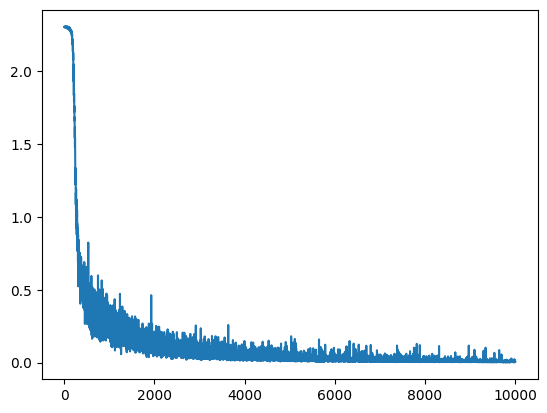

In [2]:
class ThreeLayerNet:

    def __init__(self, input_size,hsize1,hsize2,output_size,weight_init_std=0.01):
        # 初始化权重
        self.params = {}
        self.params["W1"]=weight_init_std*np.random.randn(input_size,hsize1)
        self.params["b1"]=np.zeros(hsize1)
        self.params["W2"]=weight_init_std*np.random.randn(hsize1,hsize2)
        self.params["b2"]=np.zeros(hsize2)
        self.params["W3"]=weight_init_std*np.random.randn(hsize2,output_size)
        self.params["b3"]=np.zeros(output_size)

        # 生成层
        self.layers=OrderedDict()  #有序字典
        self.layers["Affine1"]=Affine(self.params["W1"],self.params["b1"])
        self.layers['Relu1']=Relu()
        self.layers["Affine2"]=Affine(self.params["W2"],self.params["b2"])
        self.layers['Relu2']=Relu()
        self.layers["Affine3"]=Affine(self.params["W3"],self.params["b3"])
        self.lastLayer=SoftmaxWithLoss()

        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : 
            t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
 
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1']=self.layers['Affine1'].dW
        grads["b1"]=self.layers['Affine1'].db
        grads['W2']=self.layers['Affine2'].dW
        grads["b2"]=self.layers['Affine2'].db
        grads['W3']=self.layers['Affine3'].dW
        grads["b3"]=self.layers['Affine3'].db
        return grads
# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = ThreeLayerNet(784,250,250,10) #多给点

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list3 = []
train_acc_list3 = []
test_acc_list3 = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 梯度
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 更新
    for key in ('W1','b1','W2','b2','W3','b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list3.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list3.append(train_acc)
        test_acc_list3.append(test_acc)
        print(train_acc, test_acc)
import matplotlib.pyplot as plt
plt.cla()
plt.plot(train_loss_list3)

## 四层网络

0.09751666666666667 0.0974
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.11236666666666667 0.1135
0.36778333333333335 0.3618
0.64955 0.6374
0.86465 0.866
0.9045166666666666 0.9008
0.8939166666666667 0.89
0.9307333333333333 0.9253
0.939 0.9356
0.9365 0.9286
0.9399833333333333 0.9355
0.9434833333333333 0.939
0.9491 0.9411
0.9521333333333334 0.946
0.9511 0.9423
0.9552333333333334 0.9466
0.9545833333333333 0.9437
0.9603333333333334 0.9482


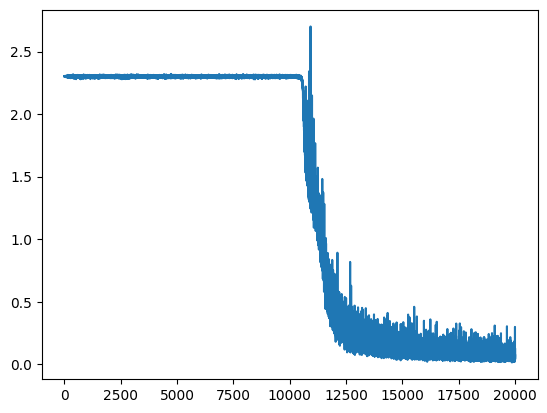

In [12]:
class FourLayerNet:

    def __init__(self, input_size,hsize1,hsize2,hsize3,output_size,weight_init_std=0.01):
        # 初始化权重
        self.params = {}
        self.params["W1"]=weight_init_std*np.random.randn(input_size,hsize1)
        self.params["b1"]=np.zeros(hsize1)
        self.params["W2"]=weight_init_std*np.random.randn(hsize1,hsize2)
        self.params["b2"]=np.zeros(hsize2)
        self.params["W3"]=weight_init_std*np.random.randn(hsize2,hsize3)
        self.params["b3"]=np.zeros(hsize3)
        self.params["W4"]=weight_init_std*np.random.randn(hsize3,output_size)
        self.params["b4"]=np.zeros(output_size)

        # 生成层
        self.layers=OrderedDict()  #有序字典
        self.layers["Affine1"]=Affine(self.params["W1"],self.params["b1"])
        self.layers['Relu1']=Relu()
        self.layers["Affine2"]=Affine(self.params["W2"],self.params["b2"])
        self.layers['Relu2']=Relu()
        self.layers["Affine3"]=Affine(self.params["W3"],self.params["b3"])
        self.layers['Relu3']=Relu()
        self.layers["Affine4"]=Affine(self.params["W4"],self.params["b4"])
        self.lastLayer=SoftmaxWithLoss()

        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : 
            t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
 
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1']=self.layers['Affine1'].dW
        grads["b1"]=self.layers['Affine1'].db
        grads['W2']=self.layers['Affine2'].dW
        grads["b2"]=self.layers['Affine2'].db
        grads['W3']=self.layers['Affine3'].dW
        grads["b3"]=self.layers['Affine3'].db
        grads['W4']=self.layers['Affine4'].dW
        grads["b4"]=self.layers['Affine4'].db
        return grads


# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = FourLayerNet(784,20,20,20,10)

iters_num = 20000 #可能20000~30000差不多
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list4 = []
train_acc_list4 = []
test_acc_list4 = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 梯度
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 更新
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list4.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list4.append(train_acc)
        test_acc_list4.append(test_acc)
        print(train_acc, test_acc)
import matplotlib.pyplot as plt
plt.cla()
plt.plot(train_loss_list4)

## 绘图

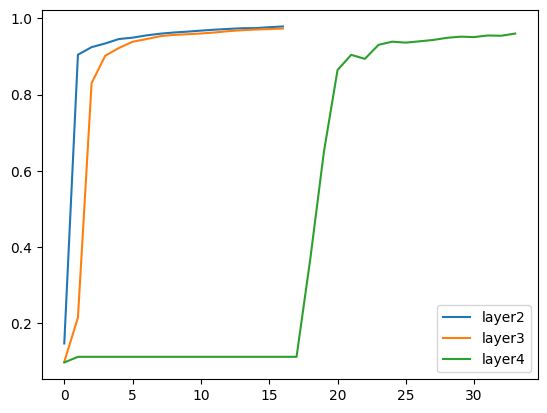

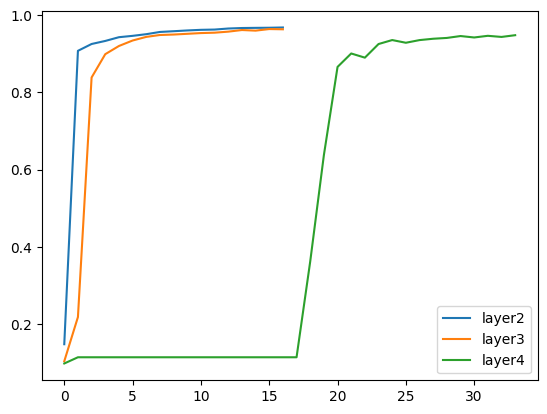

In [13]:
plt.plot(train_acc_list2)
plt.plot(train_acc_list3)
plt.plot(train_acc_list4)
plt.legend(["layer2","layer3","layer4"])
# plt.cla()
plt.figure()
plt.plot(test_acc_list2)
plt.plot(test_acc_list3)
plt.plot(test_acc_list4)
plt.legend(["layer2","layer3","layer4"])

In [14]:
import numpy as np
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 
    #若不加上面的if这一段，则很可能会溢出，导致模型表现极差
    x = x - np.max(x) # 溢出对策
    return np.exp(x) / np.sum(np.exp(x))
softmax(np.array([[1,2],[1,2]]))

array([[0.26894142, 0.73105858],
       [0.26894142, 0.73105858]])

In [15]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        print(x)
        print(np.max(x, axis=0))
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 
    #若不加上面的if这一段，则很可能会溢出，导致模型表现极差
    x = x - np.max(x) # 溢出对策
    return np.exp(x) / np.sum(np.exp(x))
softmax(np.array([[1,2,3],[1,2,3]]).T)

[[1 2 3]
 [1 2 3]]
[1 2 3]


array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]])

In [16]:
# def softmax(x):
#     if x.ndim == 2:
#         # x = x.T
#         print(x)
#         print(np.max(x, axis=1))
#         x = x - np.max(x, axis=1).T
#         y = np.exp(x) / np.sum(np.exp(x), axis=1)
#         return y
#     #若不加上面的if这一段，则很可能会溢出，导致模型表现极差
#     x = x - np.max(x) # 溢出对策
#     return np.exp(x) / np.sum(np.exp(x))
# softmax(np.array([[1,2,3],[1,2,3]]).T)